The goal of this notebook is that, given a list of experiment ID's, we download in a useful way all of the stimulus tables, dff traces, etc. As a test, we will separately looking at "tuning" to running speed for all of the different stimulus types in just primary visual cortex layer 2/3. 

Move to functions

In [1]:
#obligatory imports
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import glm_model as gm
from glm_utils import *
from scipy.stats import linregress
import pprint
import allensdk.brain_observatory.stimulus_info as stim_info
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import tensorflow as tf

%load_ext autoreload
%autoreload 2
%matplotlib inline

boc = BrainObservatoryCache(manifest_file='boc/manifest.json')

In [669]:
#first we get the list of experiment ID's we want. 

import pandas as pd

# Download experiment containers for VISp experiments, with imaging depth 350 
visp_ecs = boc.get_experiment_containers(targeted_structures=['VISp'], cre_lines=['Cux2-CreERT2'])
print("Experiment containers: %d" % len(visp_ecs))

# Download cells for a set of experiments and convert to DataFrame
cells = boc.get_cell_specimens()
cells = pd.DataFrame.from_records(cells)
print("total cells: %d" % len(cells))

# find direction selective cells in VISp
visp_ec_ids = [ ec['id'] for ec in visp_ecs ]
visp_cells = cells[cells['experiment_container_id'].isin(visp_ec_ids)]

print("Layer 2/3 cells from primary visual cortex: %d" % len(visp_cells))

Experiment containers: 12
total cells: 18260
Layer 2/3 cells from primary visual cortex: 3978


In [670]:
exp = boc.get_ophys_experiments(experiment_container_ids=list(visp_cells.experiment_container_id.unique()) )

exp_id_list = [ec['id'] for ec in exp]

data_set = {exp_id:boc.get_ophys_experiment_data(exp_id) for exp_id in exp_id_list}

map_dic = {exper['id']:exper['experiment_container_id'] for exper in exp}

In [671]:
#data = pd.DataFrame(columns = ['cell_id', 'dg_dff', 'sg_dff', 'mov1_dff', 'mov2_dff', 'mov_3dff', 'scenes_dff', 'noise_dff', 'spont_dff'
#                   'dg_run', 'sg_run','mov1_run', 'mov2_run', 'mov_3run', 'scenes_run', 'noise_run', 'dg_table', 'sg_table'])


ds_data = {}
for ds in data_set.keys():
        
    _, dff = data_set[ds].get_dff_traces()
    cells = data_set[ds].get_cell_specimen_ids()
    
    data = {'cell_ids':cells, 'raw_dff':dff }
    for stimulus in data_set[ds].list_stimuli():
        
        if stimulus == 'spontaneous':      
            table = data_set[ds].get_spontaneous_activity_stimulus_table()
        else:
            table = data_set[ds].get_stimulus_table(stimulus)
            
        data[stimulus] = table
 

    dxcm, dxtime = data_set[ds].get_running_speed()
    data['running_speed'] = dxcm
    
    ds_data[ds] = data
            

In [672]:
arranged_data = {}

for ds in data_set.keys():
    dff_data = ds_data[ds]
    
    data = {}
    for stimulus in data_set[ds].list_stimuli():
        rs = np.zeros([1])
        dfof = np.zeros([len(dff_data['cell_ids']), 1])
        for index, row in dff_data[stimulus].iterrows():
            dfof = np.concatenate((dfof, dff_data['raw_dff'][:, row['start']: row['end']]), axis = 1)
            rs = np.concatenate((rs, dff_data['running_speed'][row['start']: row['end']]), axis = 0)     

        data[stimulus + '_rs'] = np.array(np.squeeze(rs))
        data[stimulus + '_dff'] = np.array(np.squeeze(dfof))
        
    arranged_data[ds] = data  

/Users/ameliachristensen/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/ameliachristensen/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [673]:
#need to stack things neuron-wise. Non trivial

tb_data = {}

for ds_id in arranged_data.keys():
    
    data  = arranged_data[ds_id]
    
    _data = {'synthetic_rs': None, 'natural_rs': None, 'spontaneous_rs': None,'synthetic_dff': None, 'natural_dff': None, 'spontaneous_dff':None}
    for stimulus in data_set[ds_id].list_stimuli():
        
        if (stimulus == 'locally_sparse_noise') or ('gratings' in stimulus):
            stim_key = 'synthetic'
        elif ('natural' in stimulus):
            stim_key = 'natural'
        elif ('spontaneous' == stimulus):
            stim_key = 'spontaneous'
            
        run_speed =  np.array(data[stimulus + '_rs'])
        dff = np.array(data[stimulus + '_dff'])
        
        if _data[stim_key + '_rs'] == None:
            _data[stim_key+ '_rs'] = run_speed
        else:
            _data[stim_key + '_rs'] = np.concatenate((_data[stim_key + '_rs'], run_speed), axis = 0)

           
        if _data[stim_key + '_dff'] == None:
            _data[stim_key+ '_dff'] = dff
        else:
            _data[stim_key + '_dff'] = np.concatenate((_data[stim_key + '_dff'], dff), axis = 1)
    
    
    tb_data[ds_id] = _data

/Users/ameliachristensen/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:22: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/Users/ameliachristensen/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:28: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [375]:
def caran_curve(s, ymax, smax, sigp, sigm):
    funp = ymax * exp(-(s - smax)**2 / sigp) 
    condp = (s > smax) 
    
    funm = ymax * exp(-(s - smax)**2 / sigm)
    condm = (s <= smax) 
    
    return condp*funp + condm*funm
    
def gaus(x,a,x0,sigma):
    return a*exp(-(x-x0)**2/(2*sigma**2))

In [674]:
rs_results = {}
bin_hist = np.zeros([19, 2])
shuf_hist = np.zeros([19, 2])
from scipy.stats import levene


for ds in tb_data.keys():
      
    stim_results = {}
    
    for stimulus in data_set[ds].list_stimuli():
        
        if ('gratings' in stimulus) or (stimulus == 'locally_sparse_noise'):
            stim_key = 'synthetic'
        if ('natural' in stimulus):
            stim_key = 'natural'
        if ('spontaneous' == stimulus):
            stim_key = 'spontaneous'
        
        
        neural_responses = {k: np.ones([19,4]) for k in data_set[ds].get_cell_specimen_ids()}            
        results = {}
        run_speed = np.array(tb_data[ds][stim_key + '_rs']).flatten()
        
        
        if max(run_speed) < 20:
            pass
        else:
        
            run_speed_shuffled = np.random.permutation(run_speed)
        
            bins = stats.mstats.mquantiles(run_speed, np.linspace(0, 1, 20), limit = (0, 50))
            shuf_bins = stats.mstats.mquantiles(run_speed_shuffled, np.linspace(0, 1, 20), limit = (0, 50))
            
            for ind, k in enumerate(data_set[ds].get_cell_specimen_ids()):

                temp = np.array(tb_data[ds][stim_key + '_dff'][ind])  
                
                for i in range(1, len(bins)):
                    bin_hist[i- 1] = [bins[i -1], bins[i]]
                    shuf_hist[i-1] = [bins[i-1], bins[i]]
                    
                    idx = np.where((run_speed > bins[i-1]) & (run_speed < bins[i]))
                    shuf_idx = np.where((run_speed_shuffled > shuf_bins[i-1]) & (run_speed_shuffled < shuf_bins[i]))
                    
                    #this control shouldn't be necessary
                    if len(idx[0] != 0):
                        av = np.mean(temp[idx[0]])
                        std = np.std(temp[idx[0]])
                        std_shuf = np.std(temp[shuf_idx[0]])
                        av_shuf = np.mean(temp[shuf_idx[0]])
                    else:
                        av = 0
                        std = 0

                    neural_responses[k][i-1, 0] = av
                    neural_responses[k][i-1, 1] = std / np.sqrt(len(temp[idx[0]]))
                    neural_responses[k][i-1, 2] = av_shuf
                    neural_responses[k][i-1, 3] = std / np.sqrt(len(temp[shuf_idx[0]]))

                
                x = np.log(np.mean(bin_hist, axis = 1))
                y = np.array(neural_responses[k][:, 0])

                shuf_x = np.log(np.mean(bin_hist, axis = 1))
                shuf_y = np.array(neural_responses[k][:, 2])
                
                
                stat, pvalue = levene(y, shuf_y)
                
                n = len(x)
                
                ymax = max(y)
                xmax = x[np.where(y == ymax)[0]]
                
                rho, p = spearmanr(x, y)
                    
                results[k] = rho, p, pvalue

        stim_results[stim_key] = (neural_responses, results)    
    rs_results[ds] = stim_results

In [613]:
grouped_names = ['synthetic', 'spontaneous', 'natural']

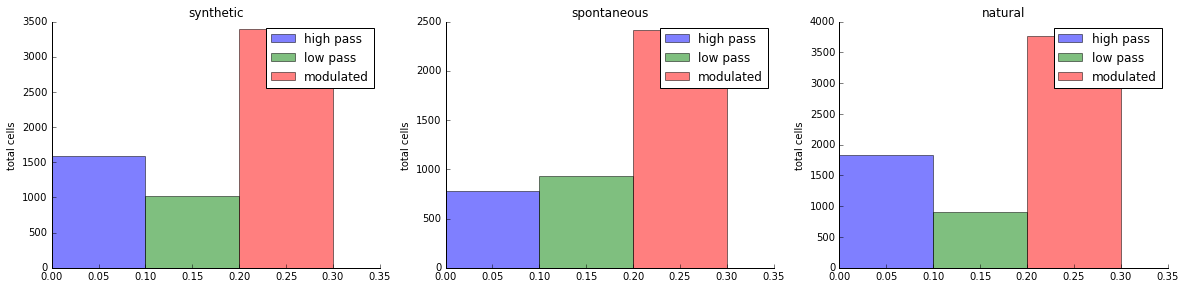

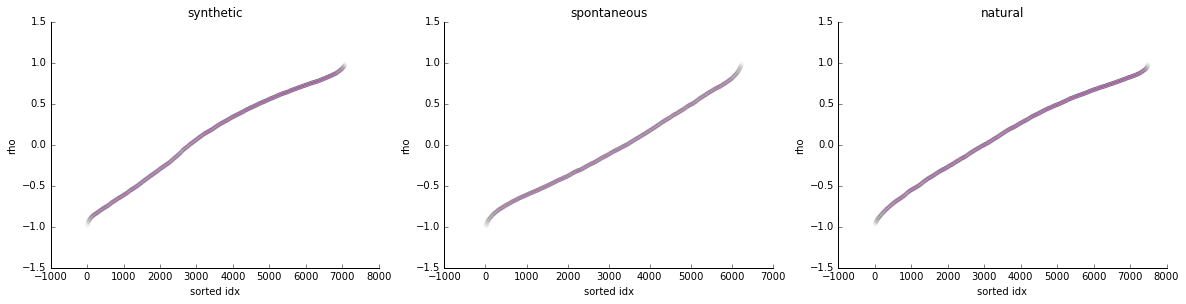

In [676]:
r_banda = {stim: 0 for stim in grouped_names}
r_inca = {stim: 0 for stim in grouped_names}
r_deca = {stim: 0 for stim in grouped_names}


r_hist = {stim: [] for stim in grouped_names}


for ds in rs_results.keys():
    stim_results = rs_results[ds]  
    for stimulus in stim_results.keys():
        
        _, results = stim_results[stimulus]
        
        for k in results.keys():
            rho, p, p_var = results[k]
            
            r_hist[stimulus].append(rho)
            
            if p_var < 0.05:
                r_banda[stimulus] += 1
            
            
                if rho < 0 and p < 0.05:
                    r_deca[stimulus] += 1

                elif rho > 0 and p < 0.05:
                    r_inca[stimulus] += 1

    

plt.figure(figsize = [20, 15])
for i, stimulus in enumerate(grouped_names):
   
    ax = plt.subplot(3, 3, i+1)
    num_cells = sum([r_inca[stimulus], r_deca[stimulus], r_banda[stimulus]])

    plt.bar(0, r_inca[stimulus], .1,  label =  'high pass', color = 'b', alpha = .5)
    plt.bar(.1, r_deca[stimulus], .1, label = 'low pass', color= 'g', alpha = .5)
    plt.bar(.2, r_banda[stimulus], .1, label= 'modulated', color='r', alpha = .5)
    plt.ylabel('total cells')
    plt.legend()
    plt.title(stimulus)
    simpleaxis(ax)
    
    
plt.show()

plt.figure(figsize = [20, 15])
for i, stimulus in enumerate(grouped_names):
   
    ax = plt.subplot(3, 3, i+1)
    rs = np.array(r_hist[stimulus])

    idx = np.argsort(rs)
    plt.scatter(range(len(rs[idx])), rs[idx], alpha = .005, c='m')

    plt.title(stimulus)
    plt.ylabel('rho')
    plt.xlabel('sorted idx')
    simpleaxis(ax)
    
    
plt.show()

synthetic


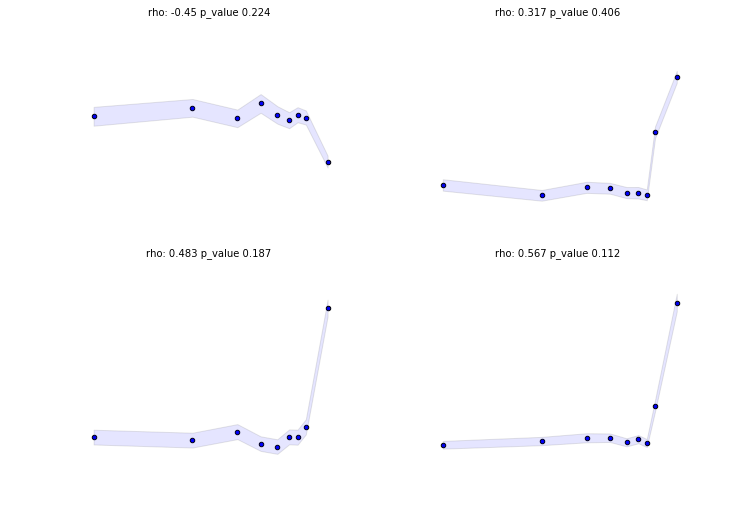

spontaneous


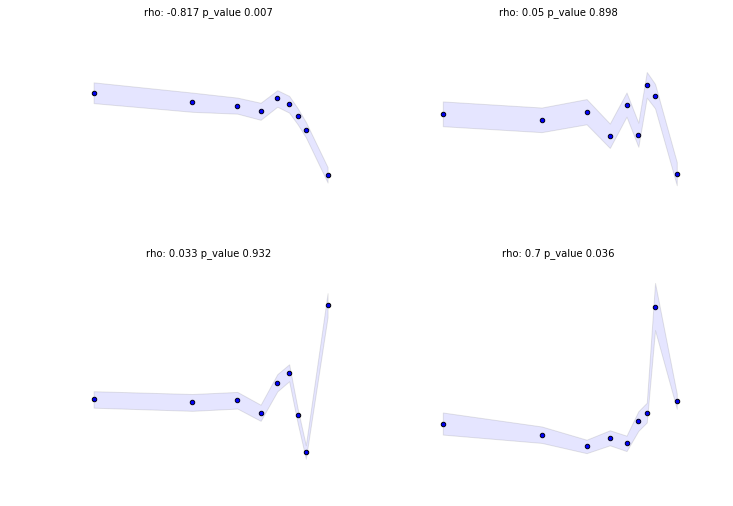

natural


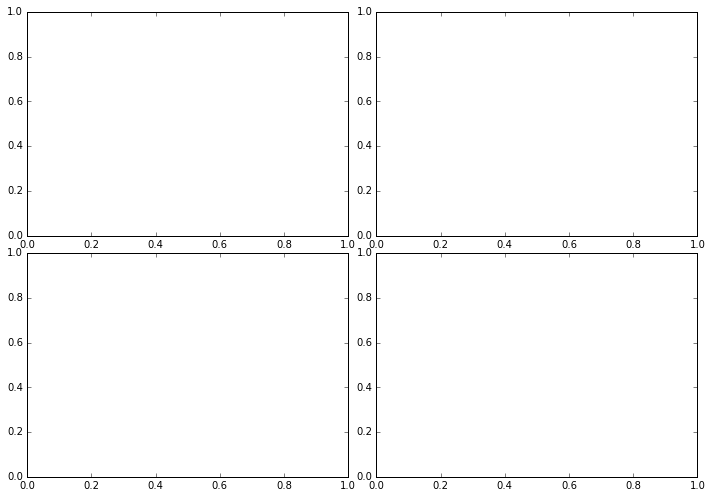

synthetic


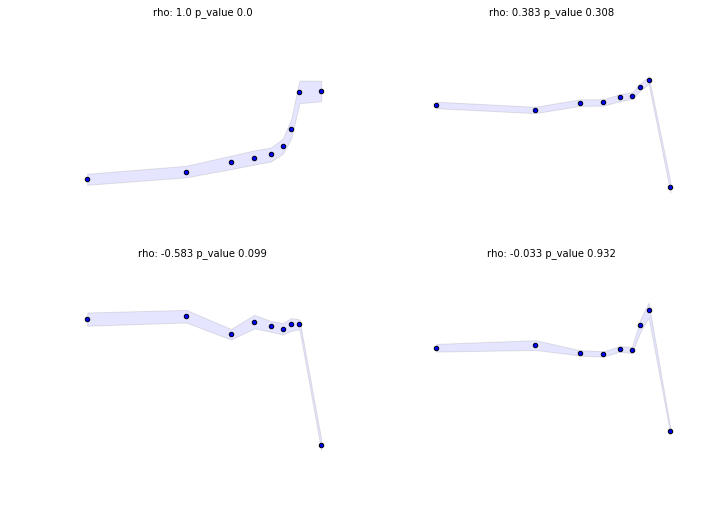

spontaneous


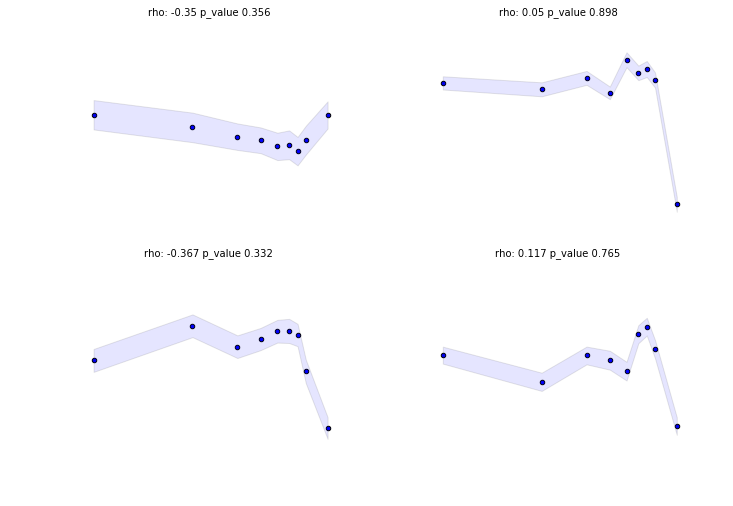

natural


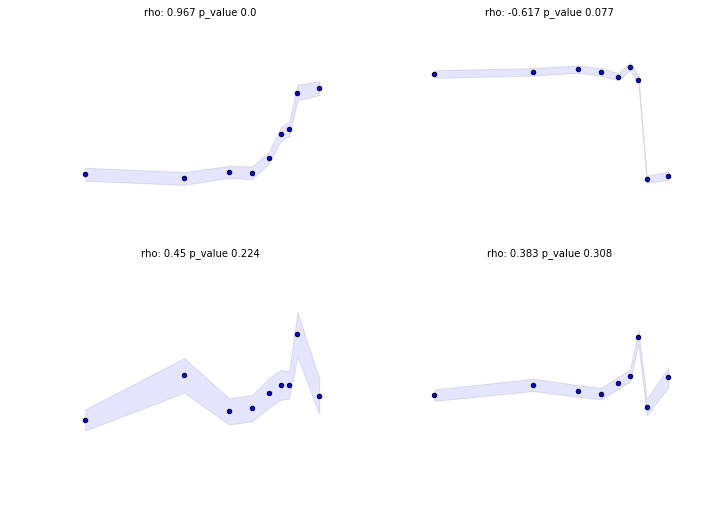

synthetic


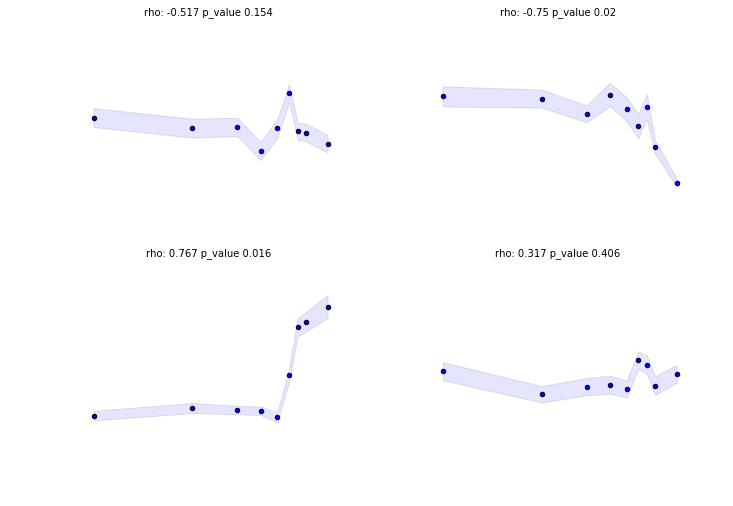

spontaneous


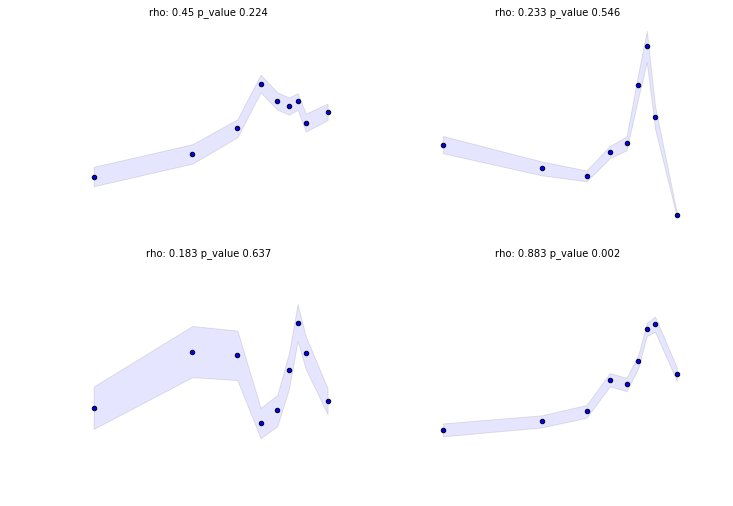

natural


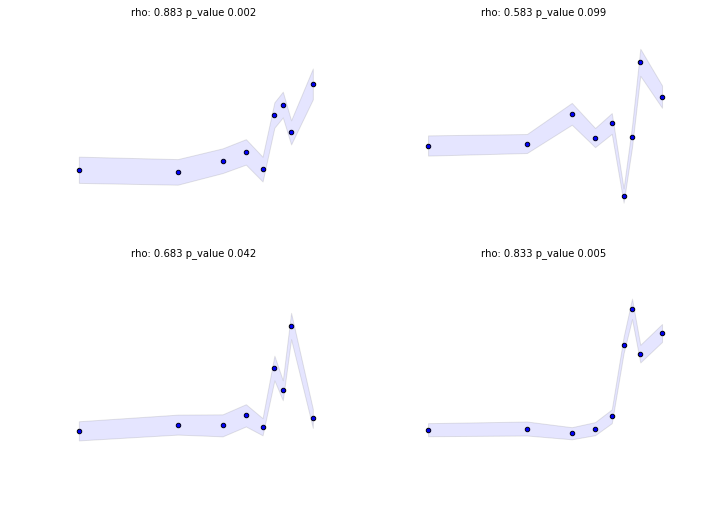

synthetic


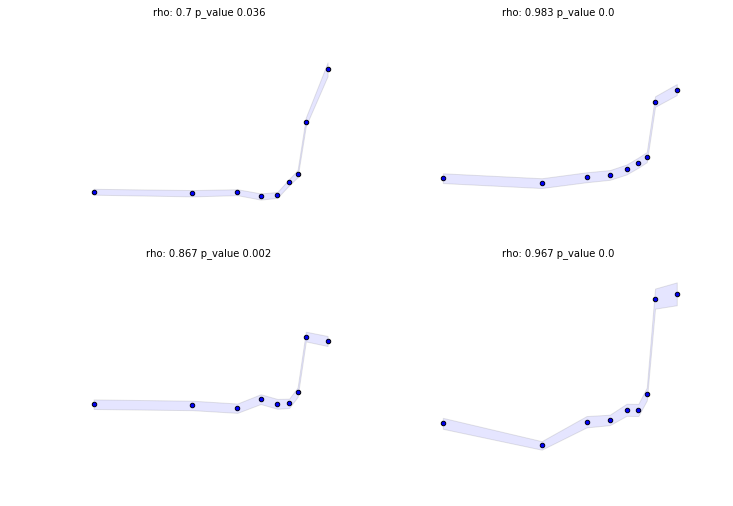

spontaneous


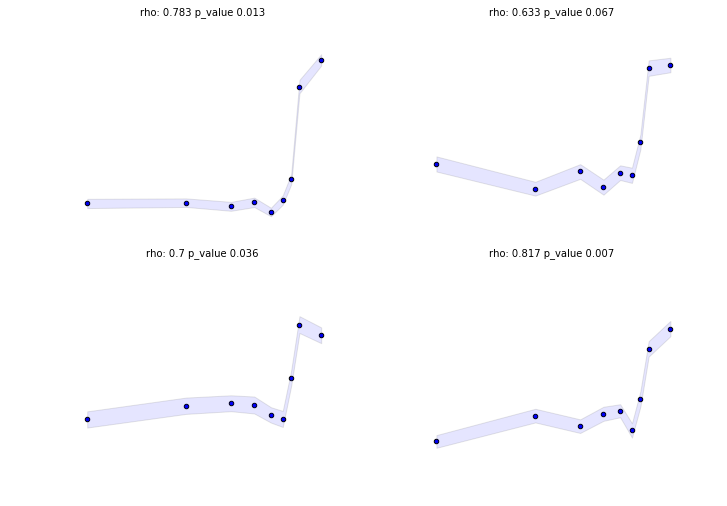

natural


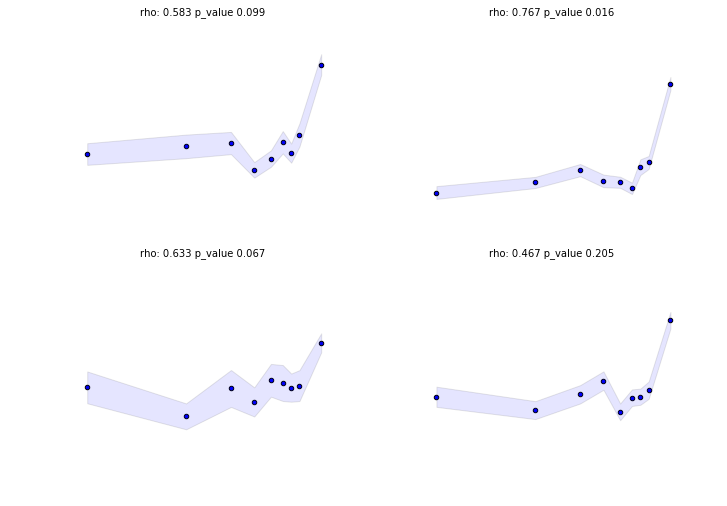

synthetic


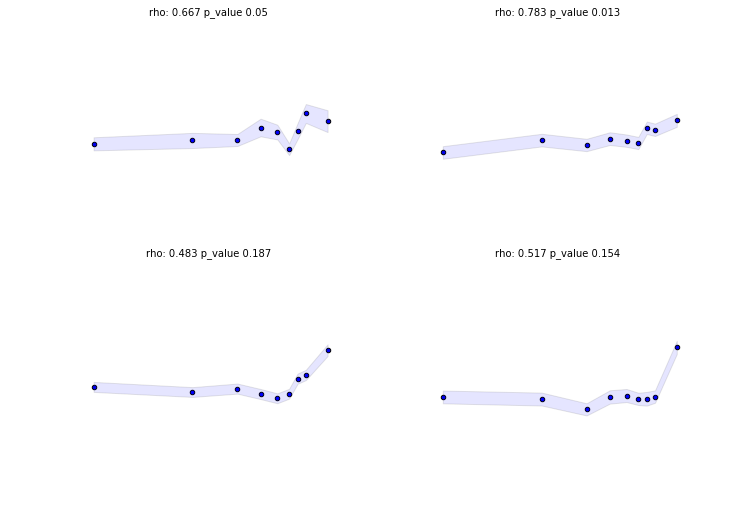

spontaneous


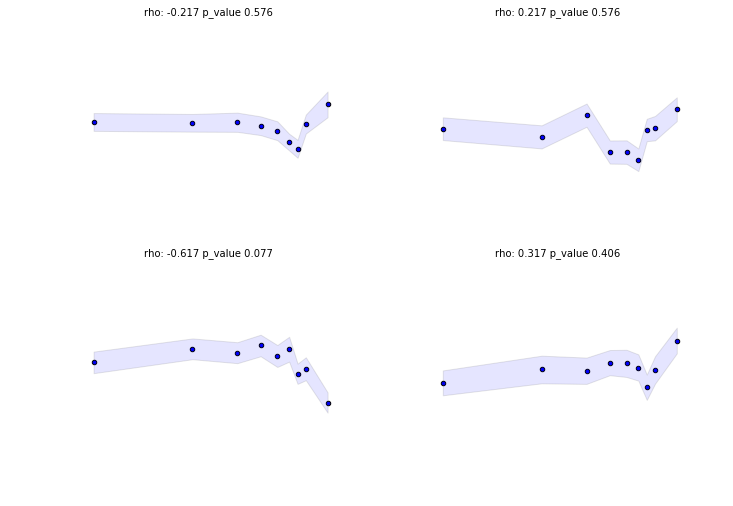

natural


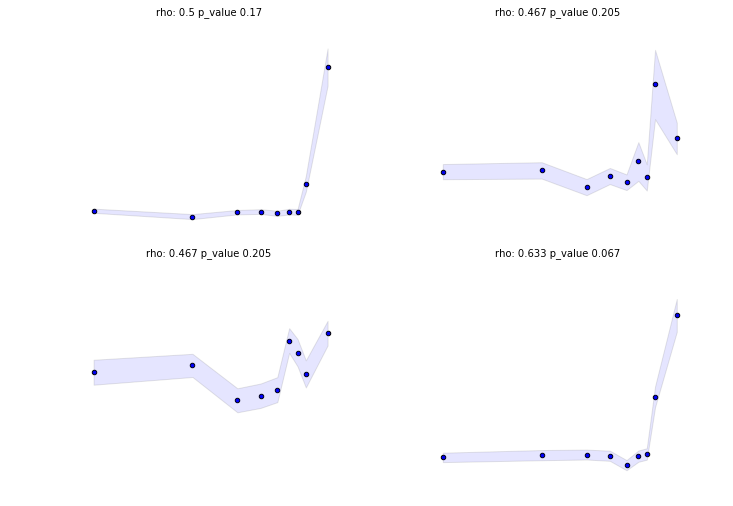

synthetic


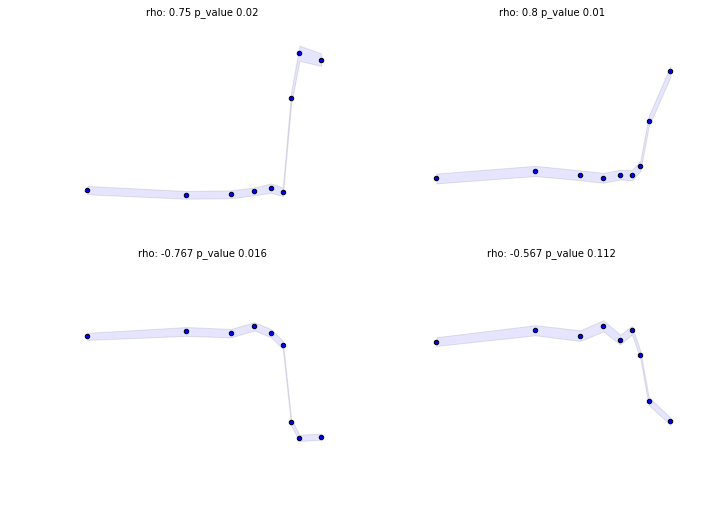

spontaneous


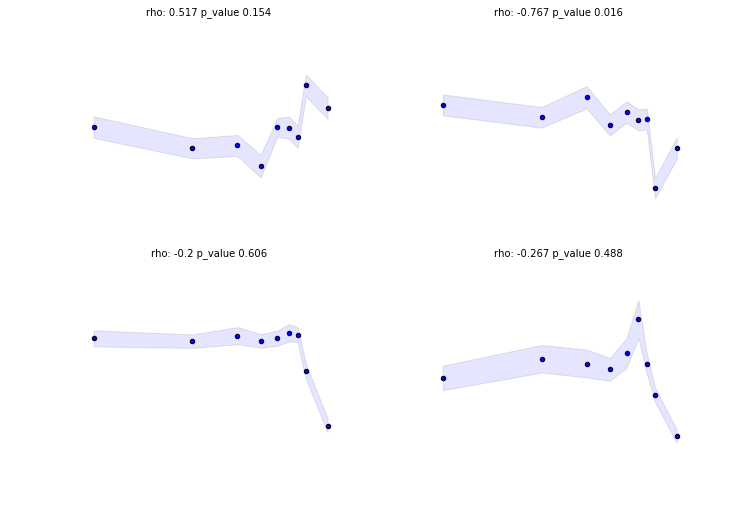

natural


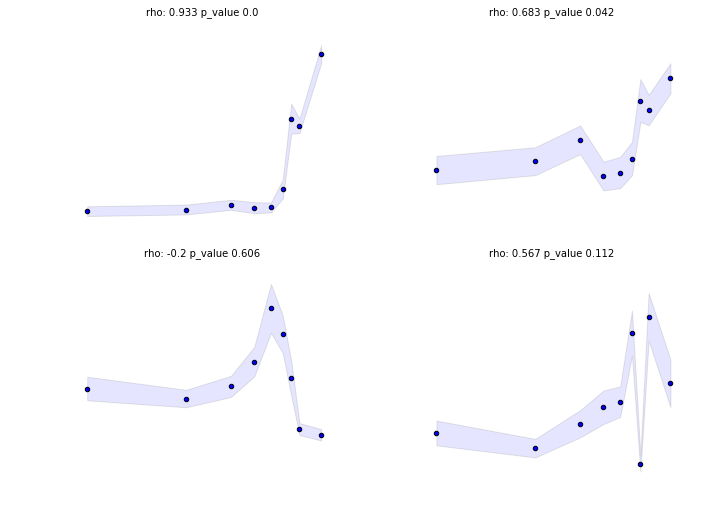

synthetic


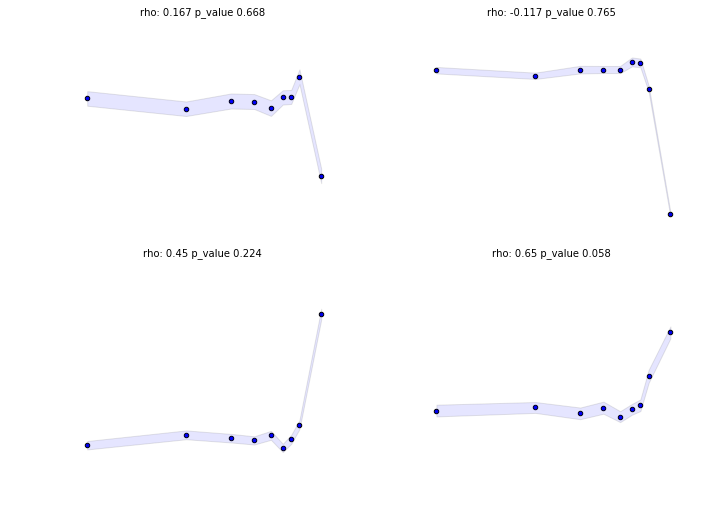

spontaneous


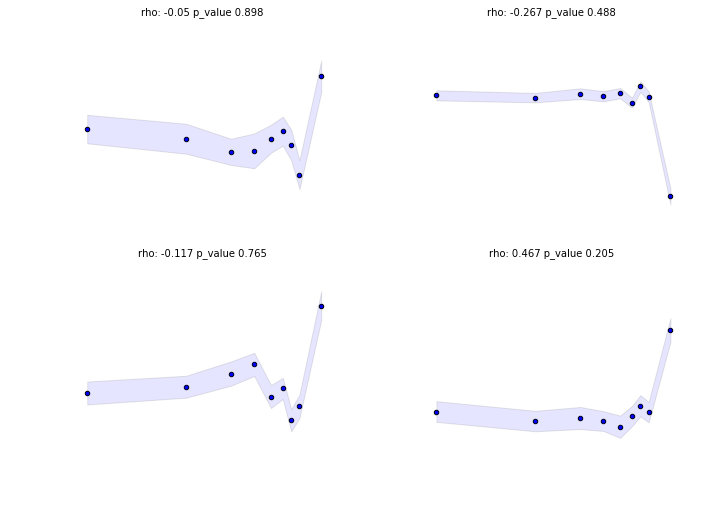

natural


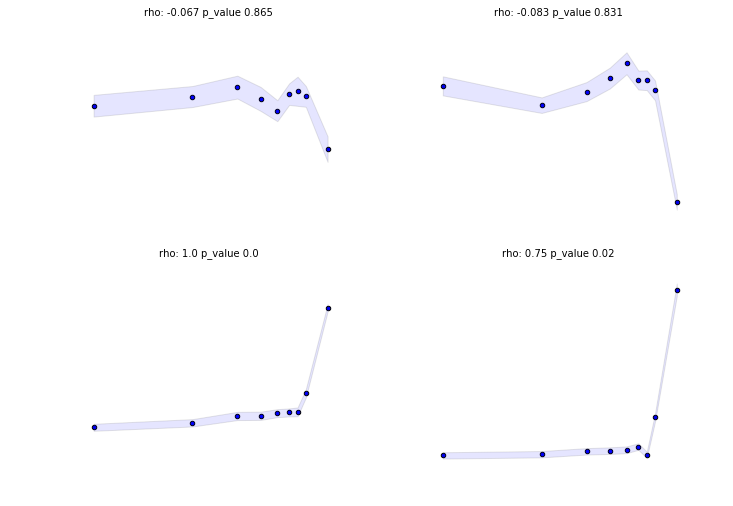

synthetic


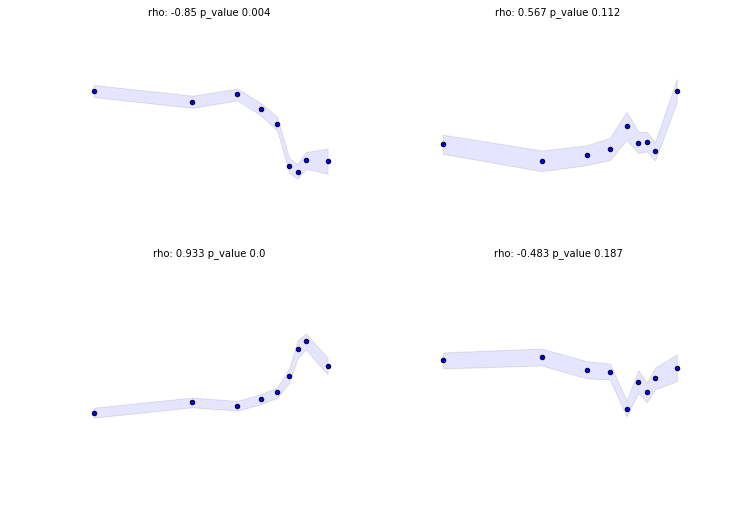

spontaneous


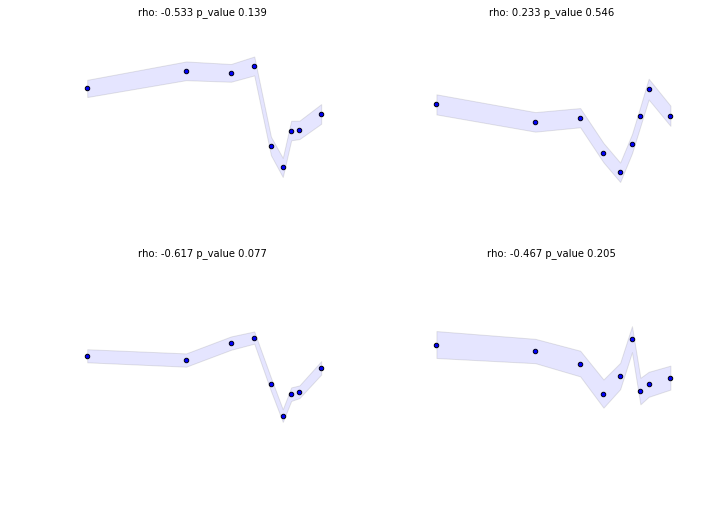

natural


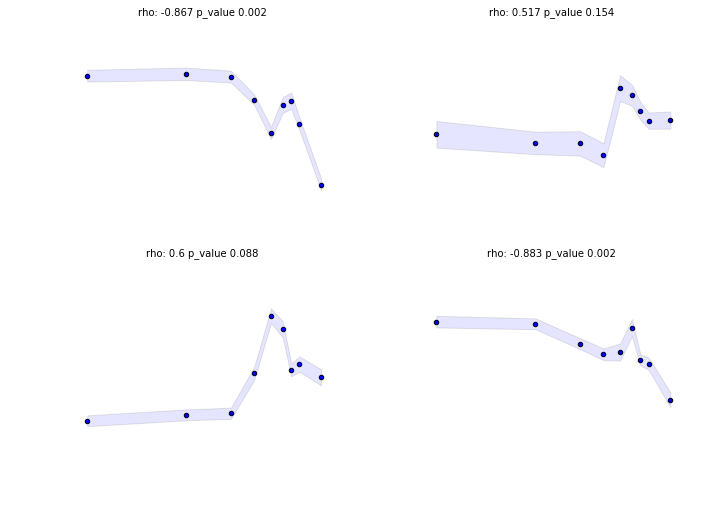

synthetic


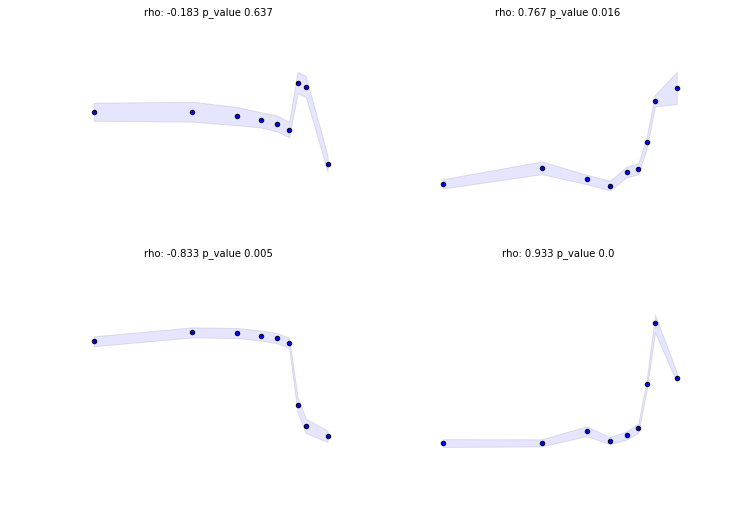

spontaneous


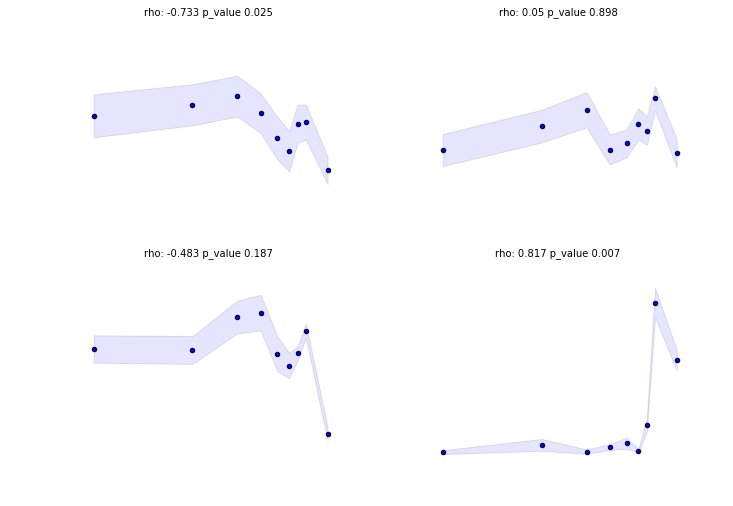

natural


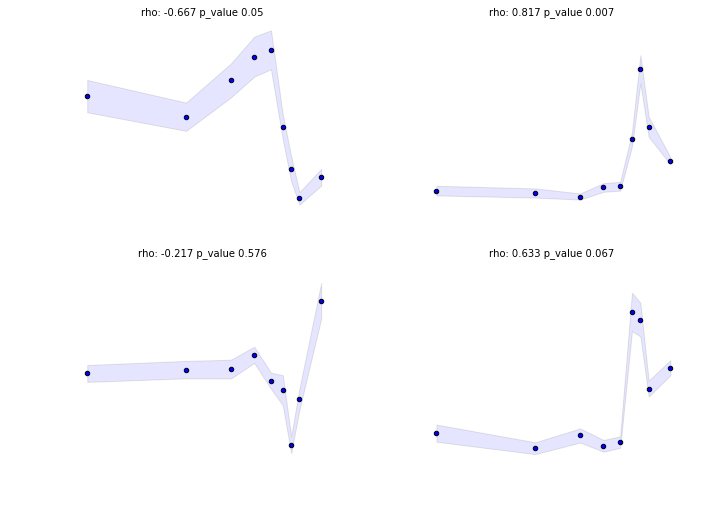

synthetic


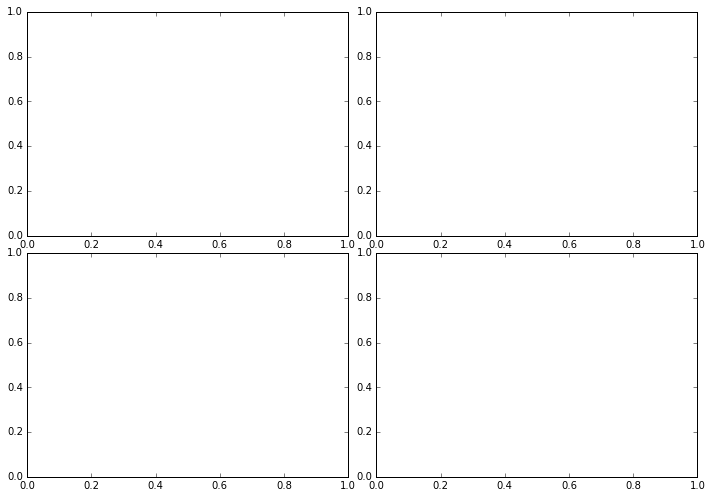

spontaneous


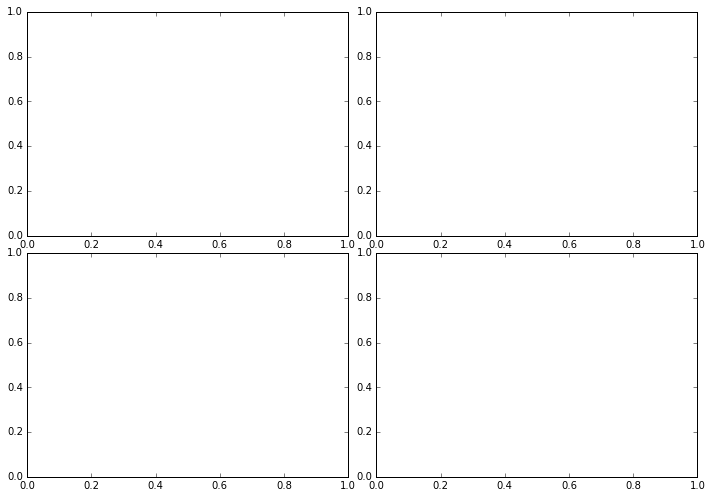

natural


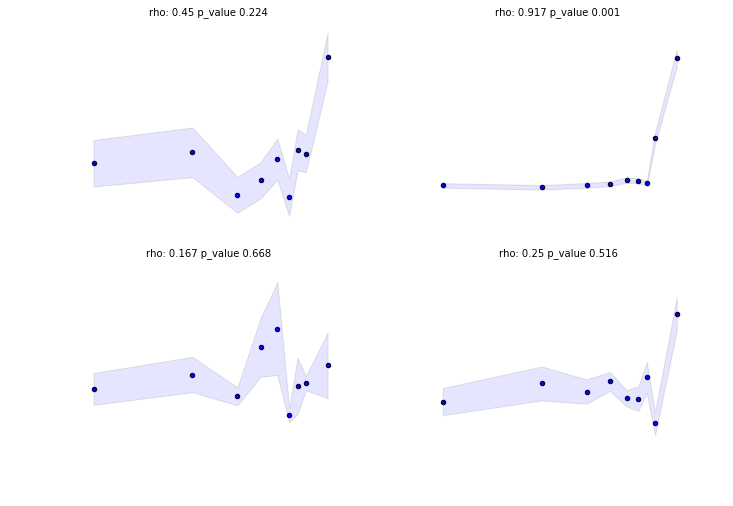

synthetic


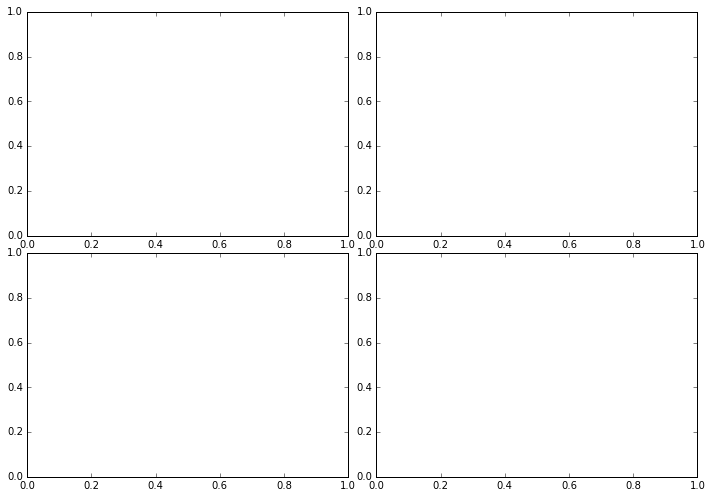

spontaneous


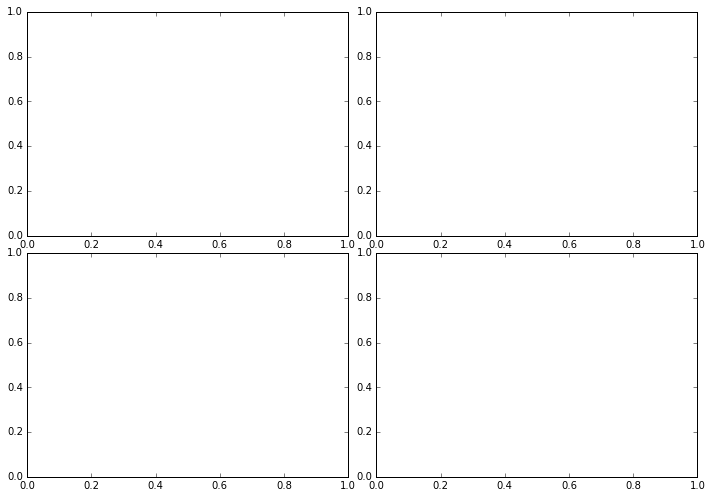

natural


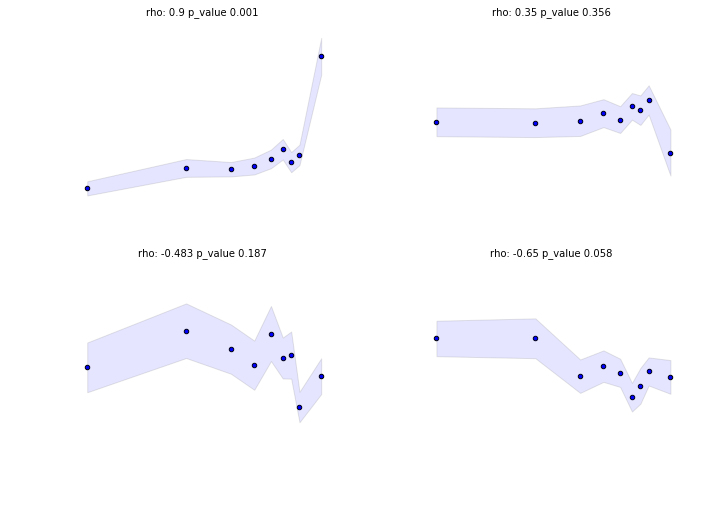

synthetic


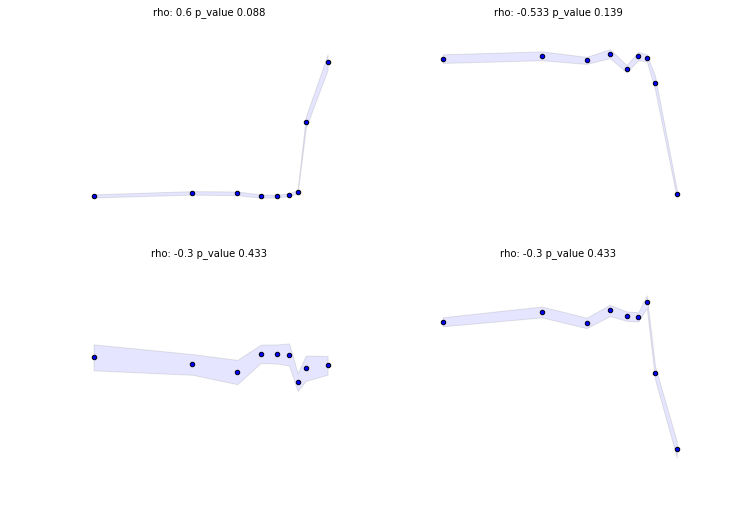

spontaneous


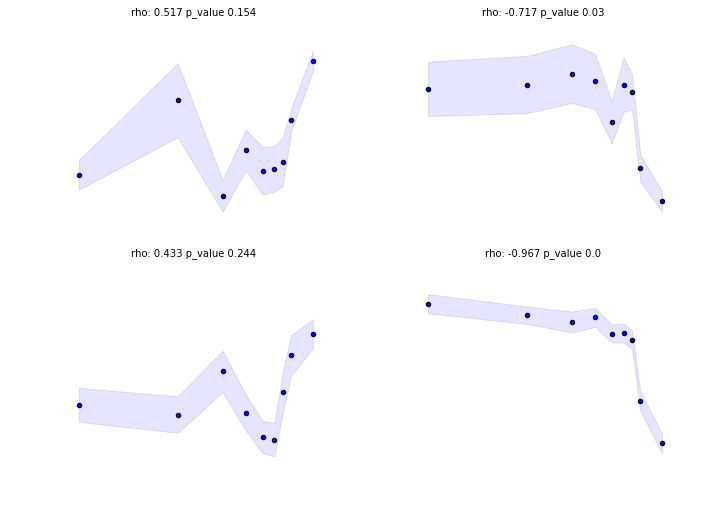

natural


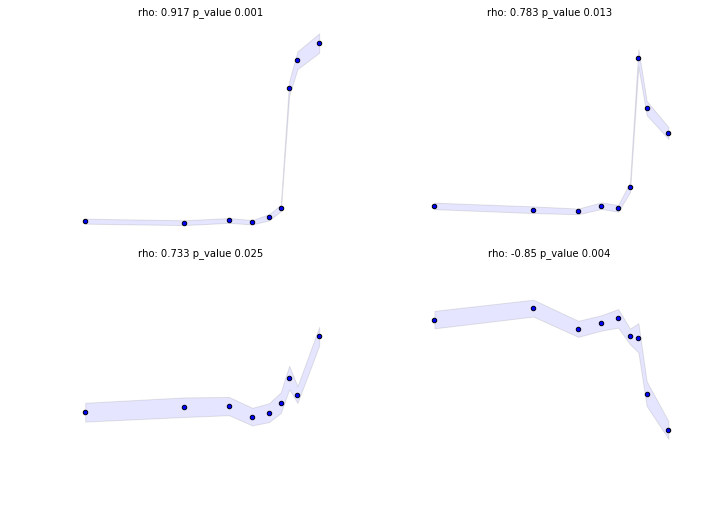

synthetic


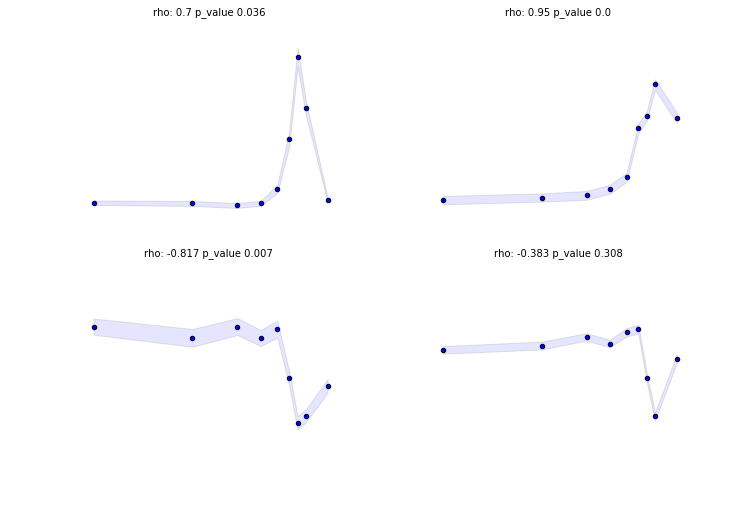

spontaneous


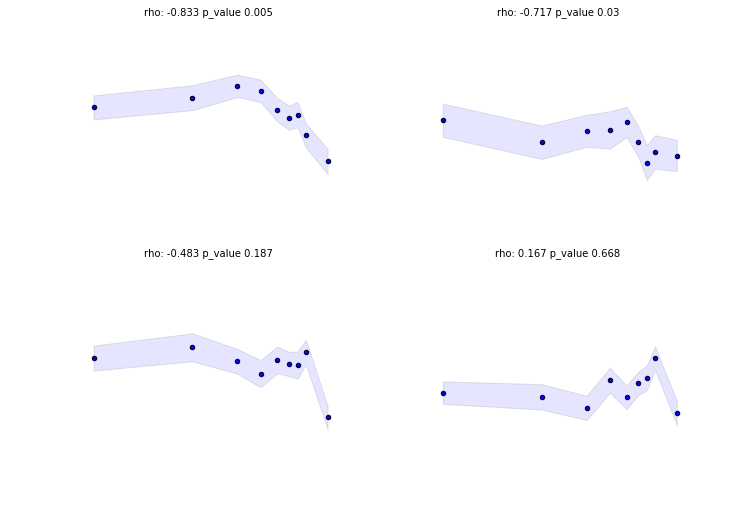

natural


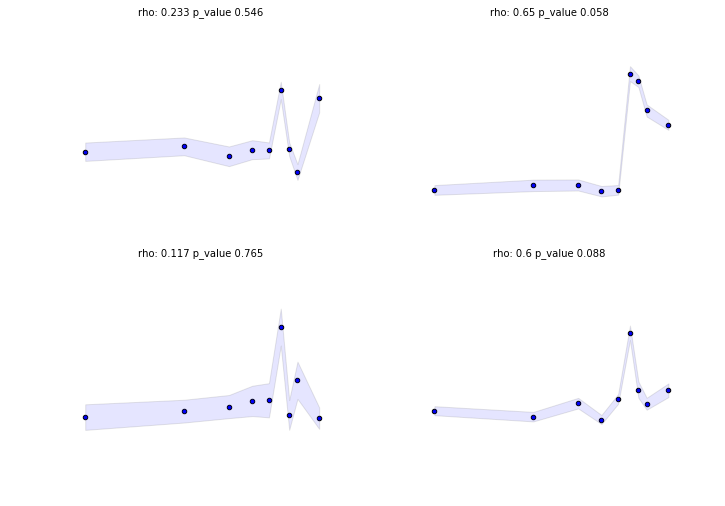

synthetic


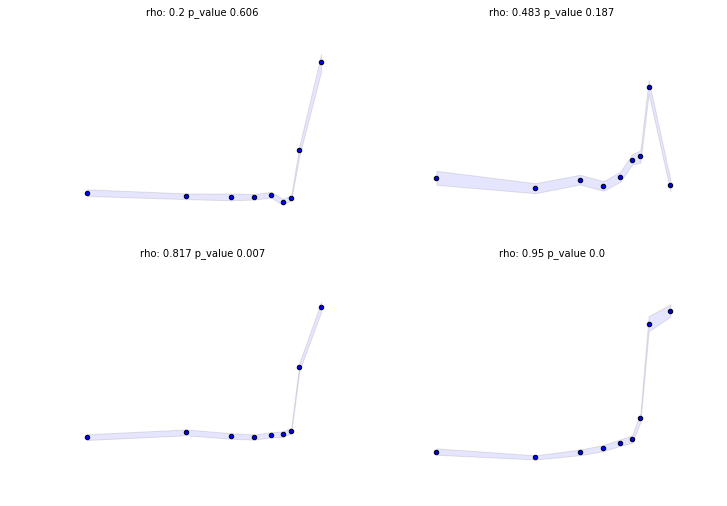

spontaneous


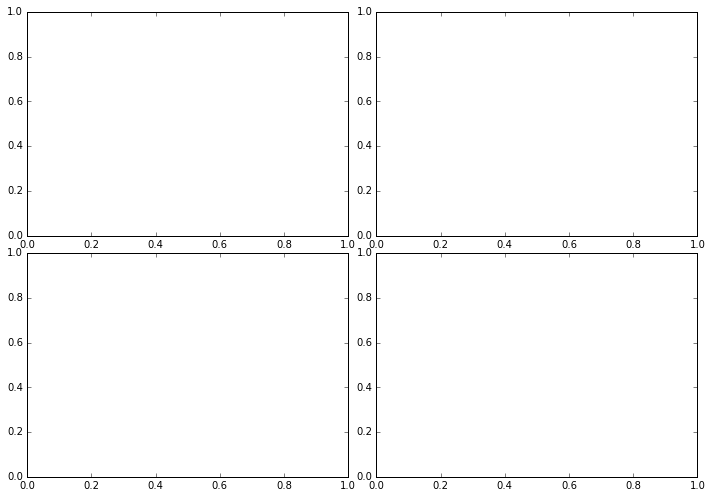

natural


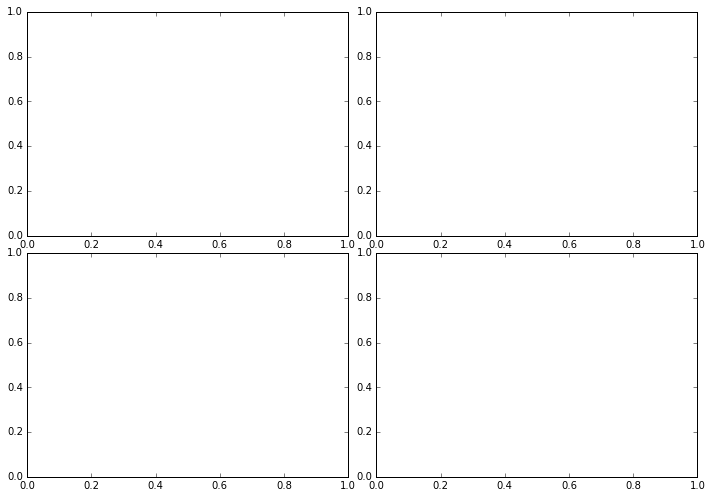

synthetic


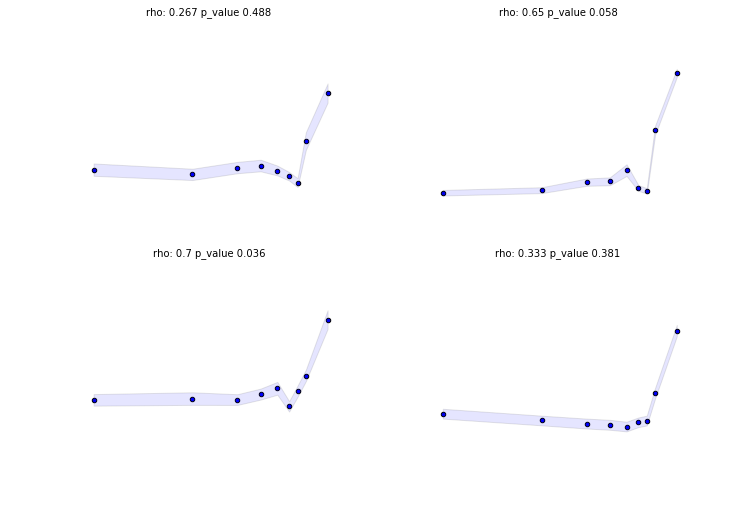

spontaneous


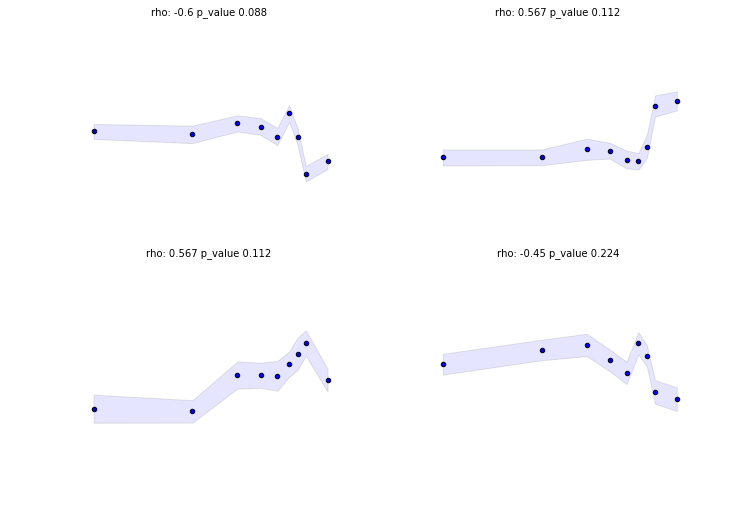

natural


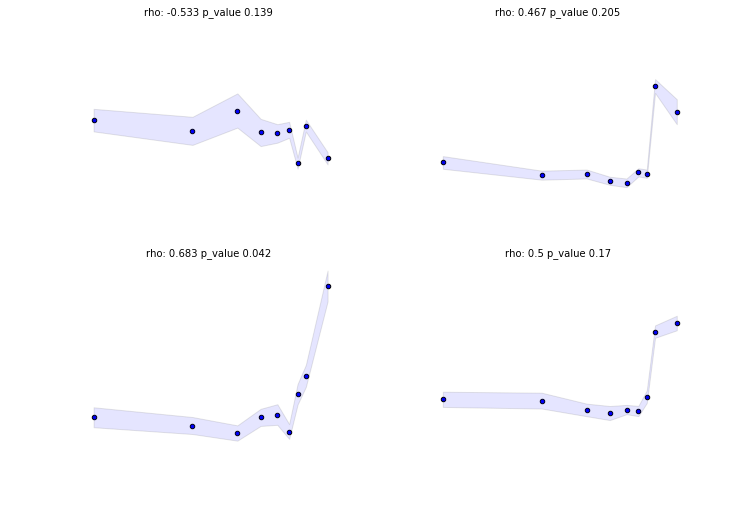

synthetic


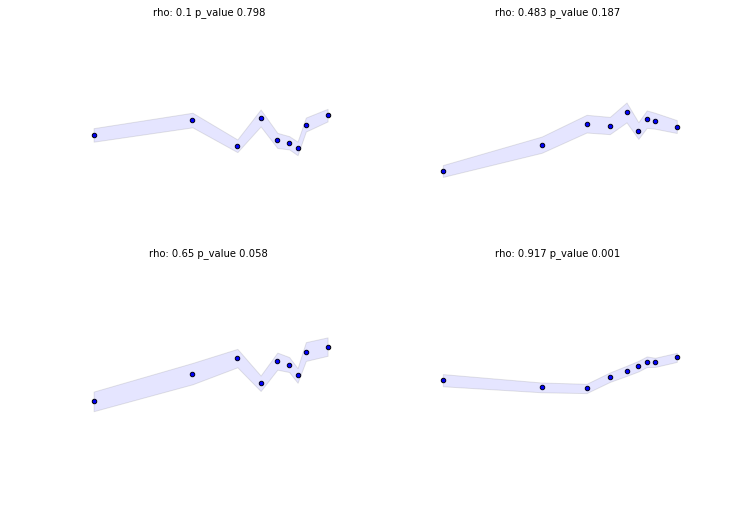

spontaneous


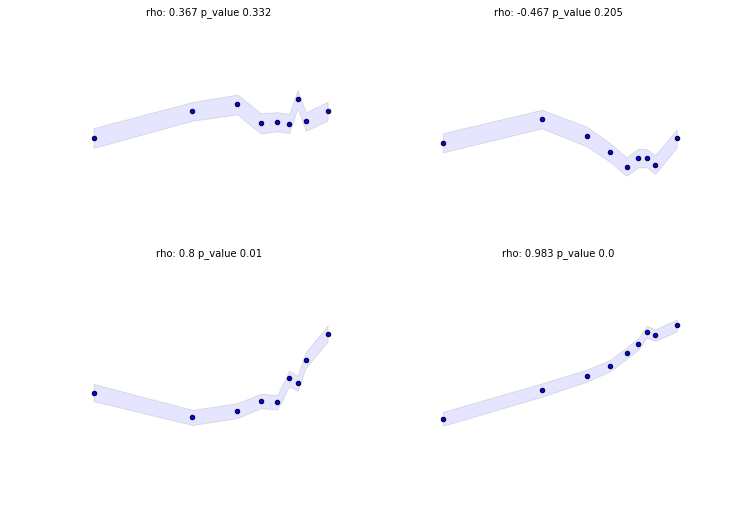

natural


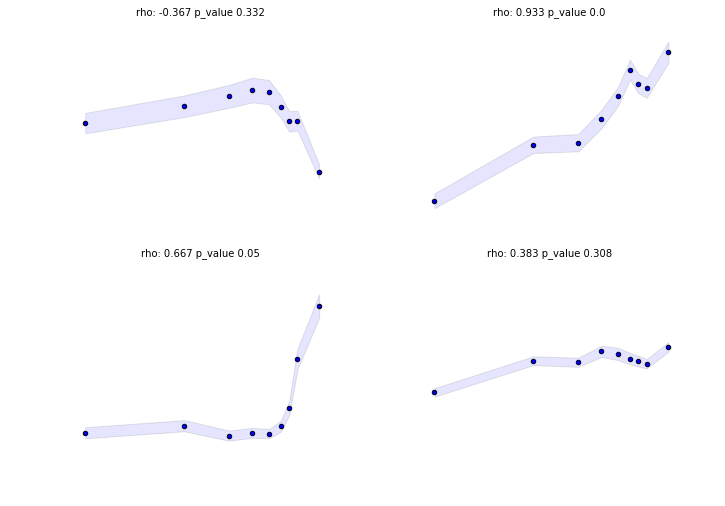

synthetic


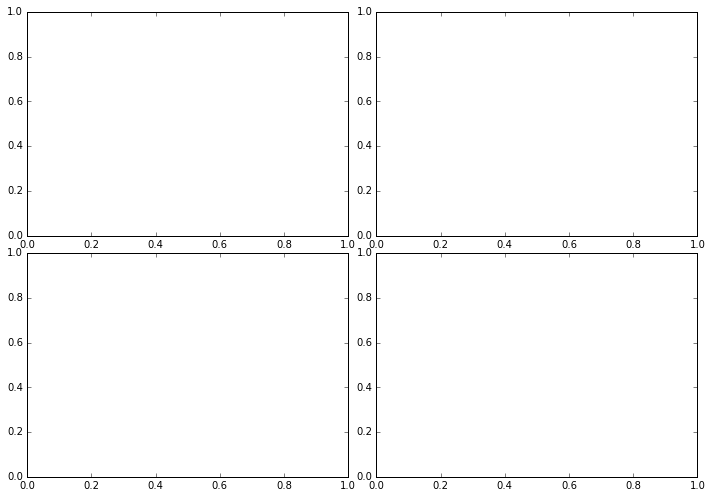

spontaneous


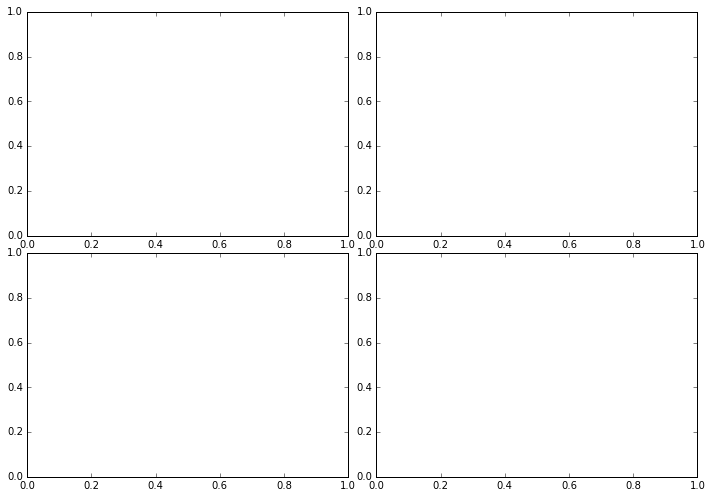

natural


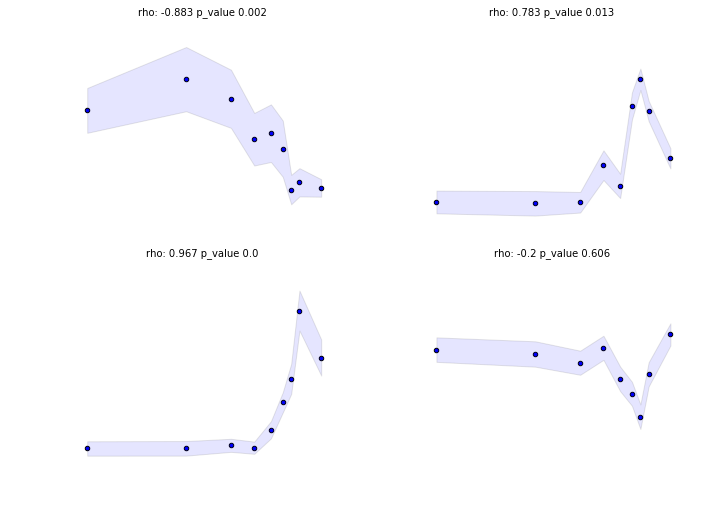

synthetic


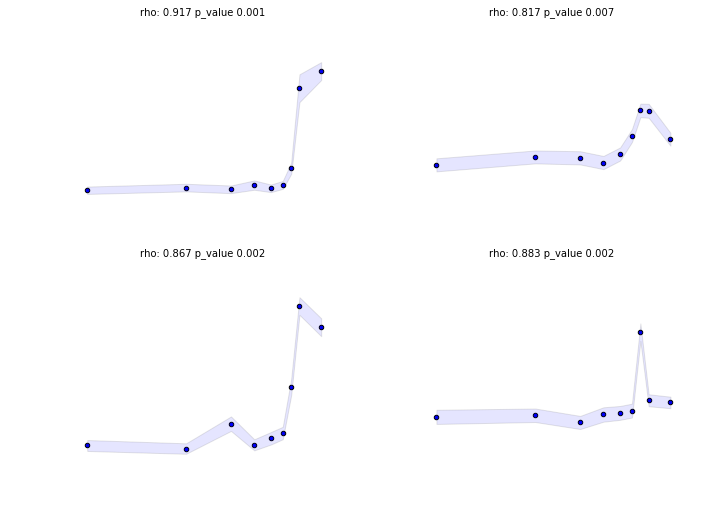

spontaneous


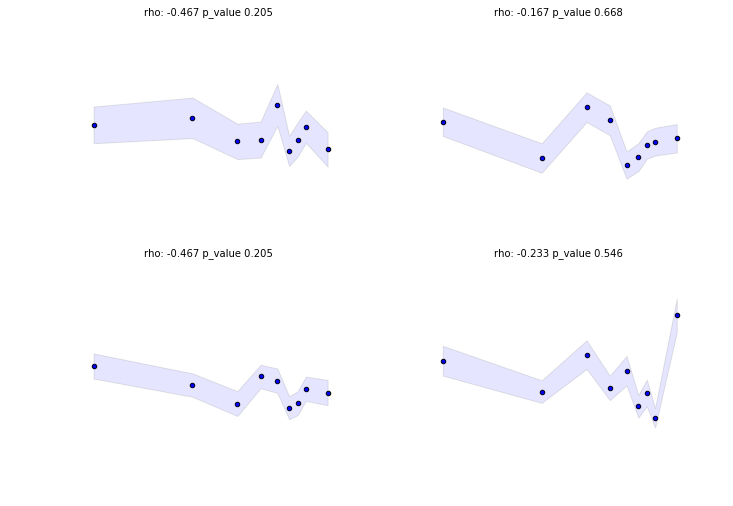

natural


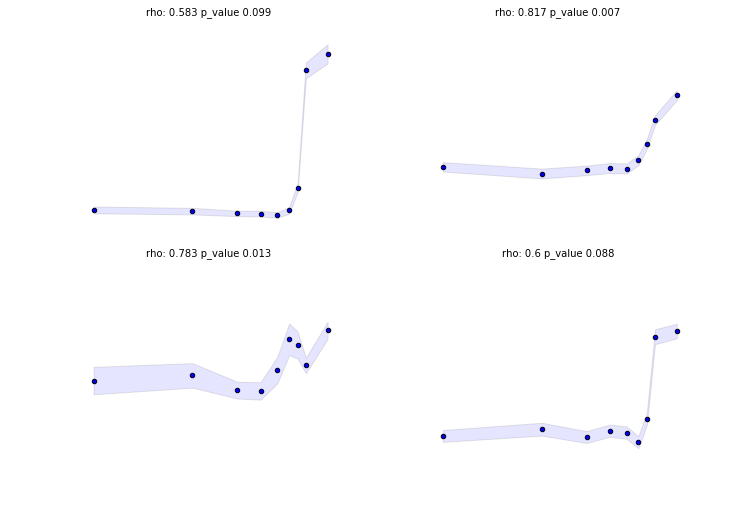

synthetic


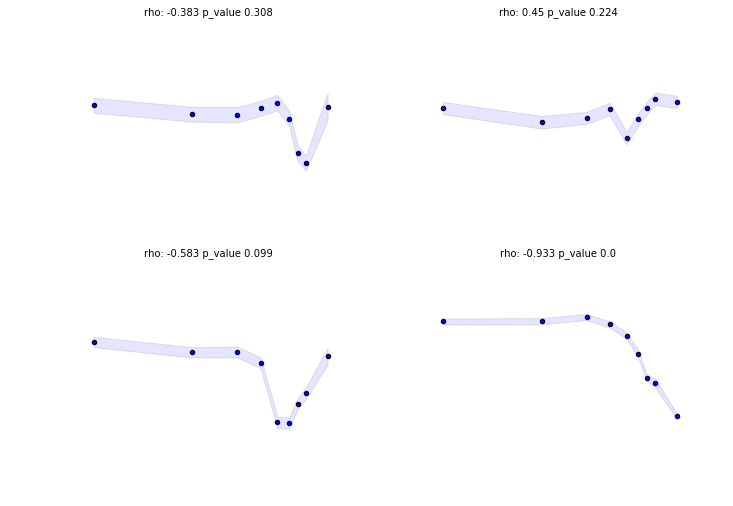

spontaneous


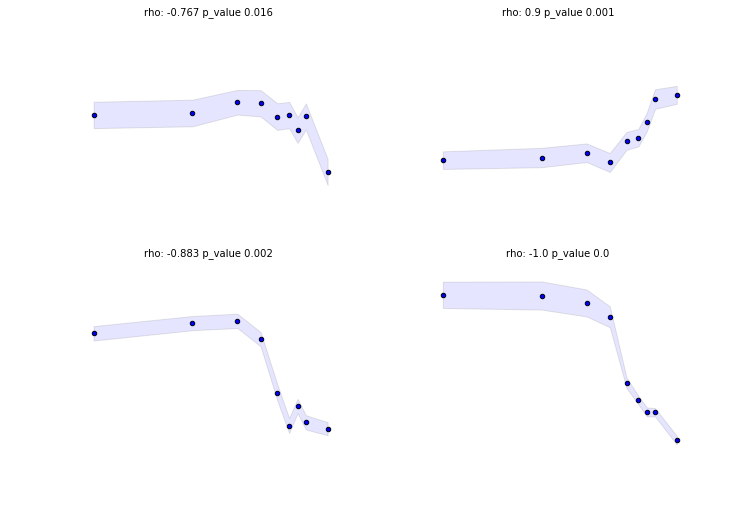

natural


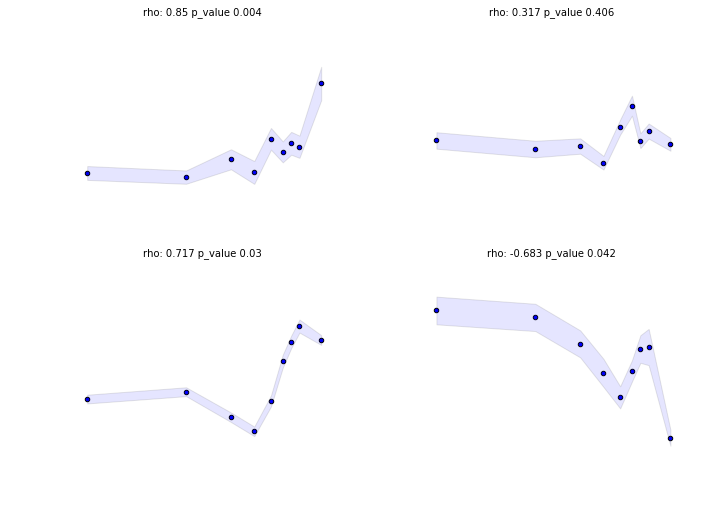

synthetic


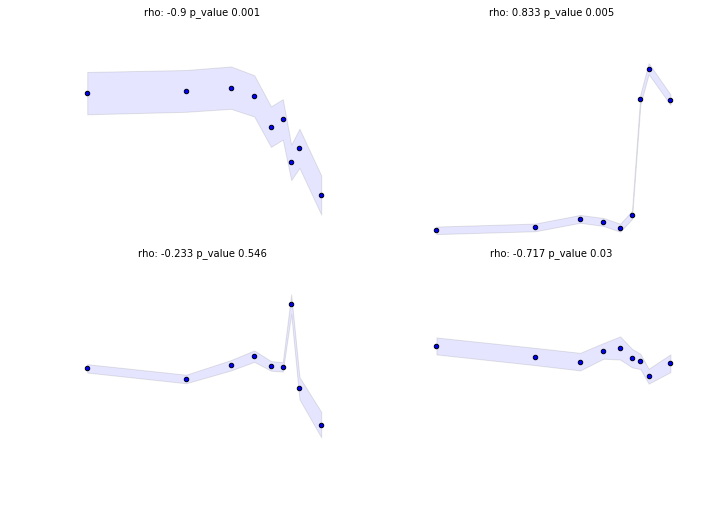

spontaneous


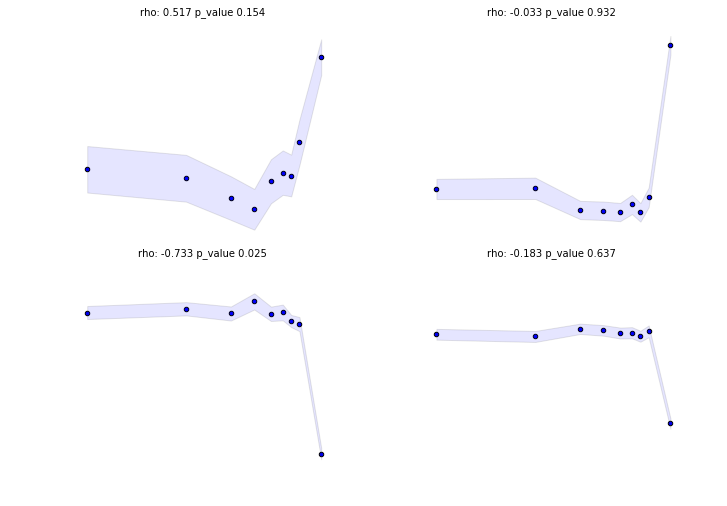

natural


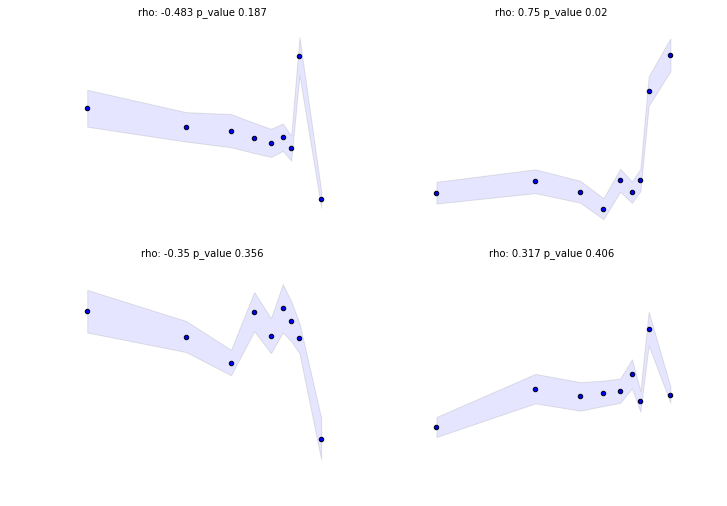

synthetic


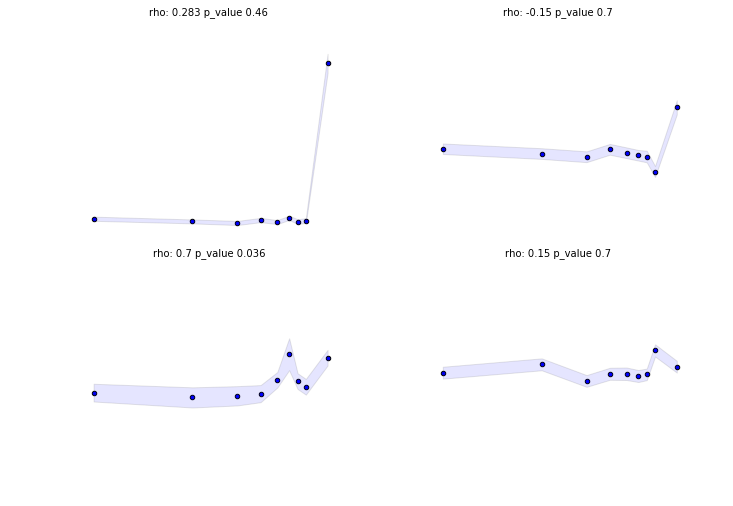

spontaneous


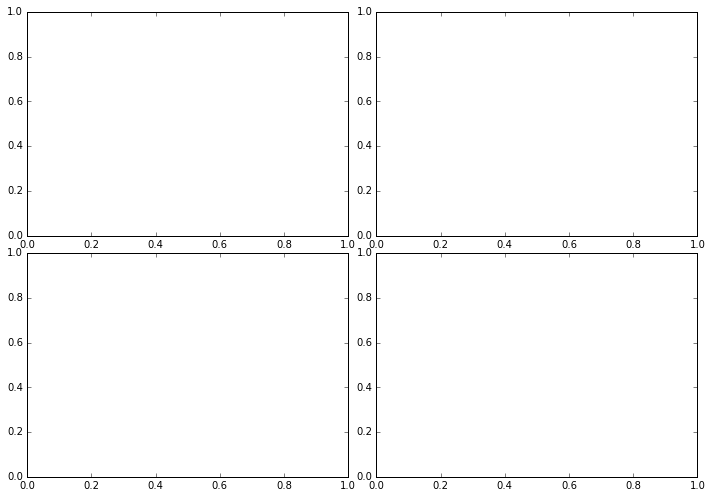

natural


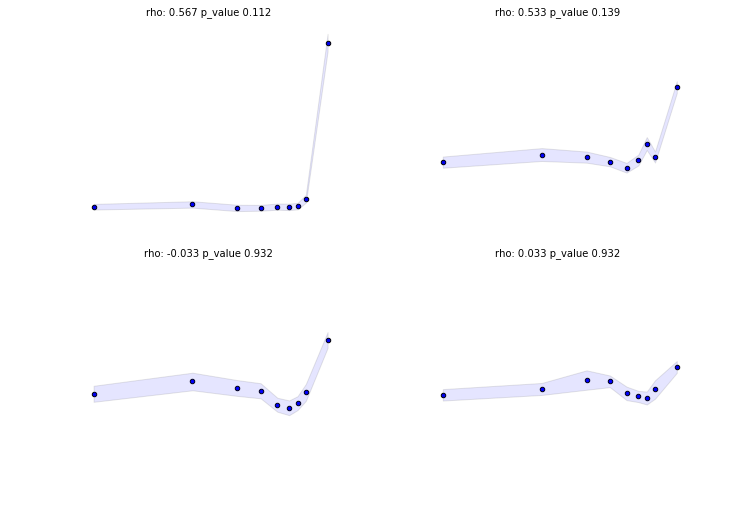

synthetic


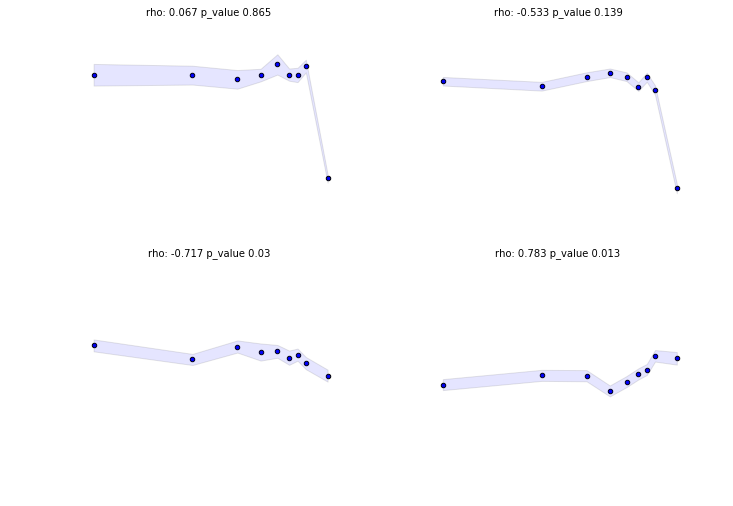

spontaneous


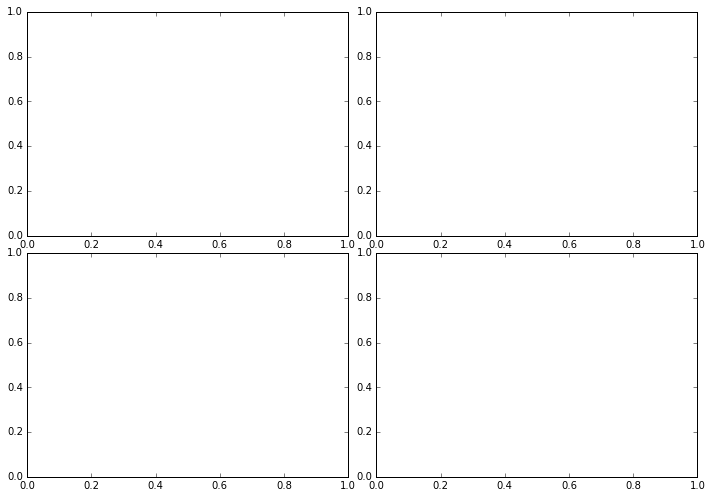

natural


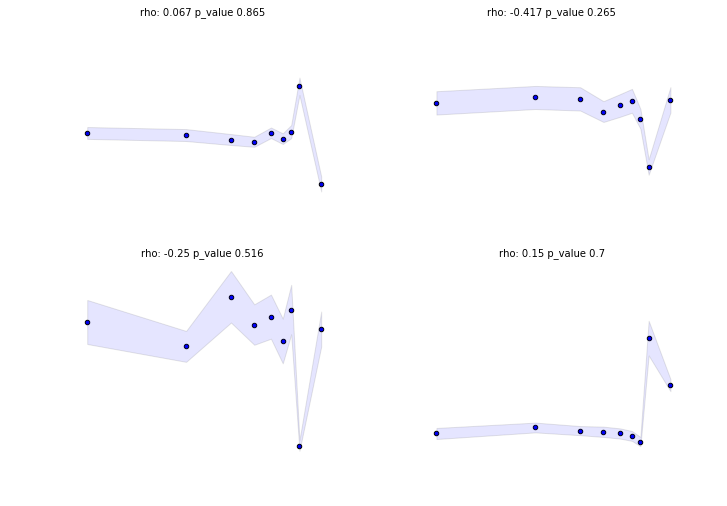

synthetic


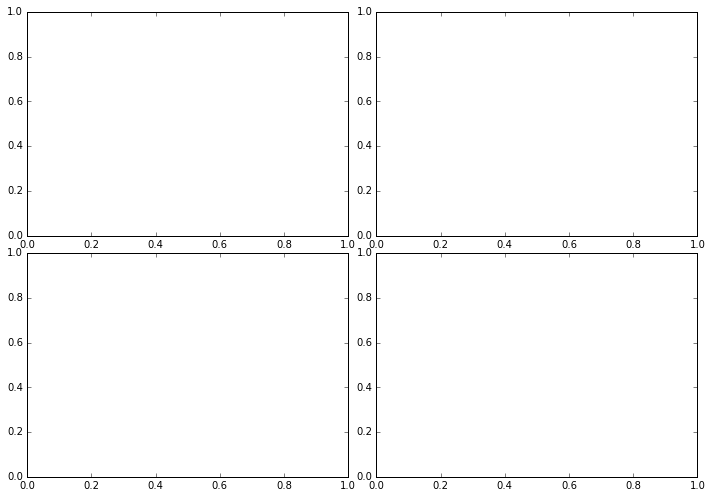

spontaneous


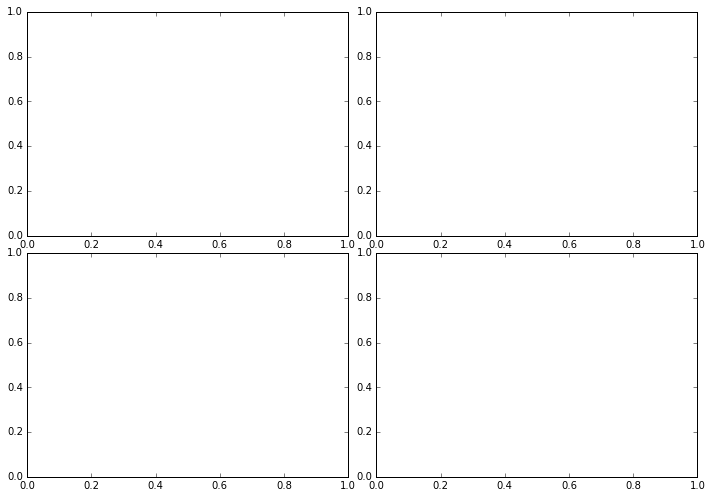

natural


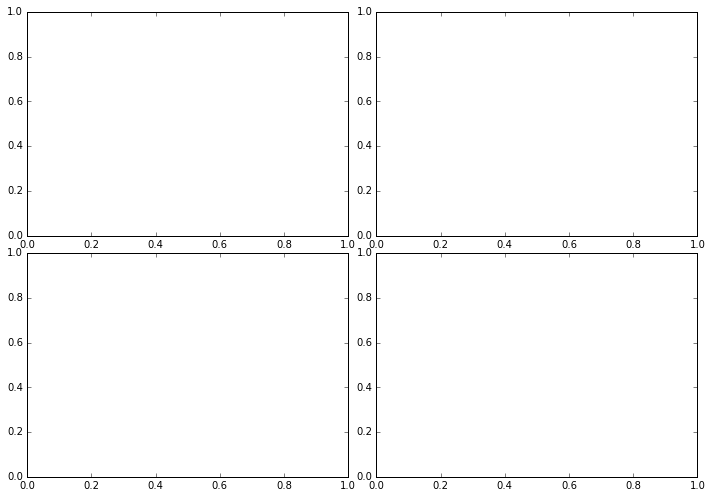

synthetic


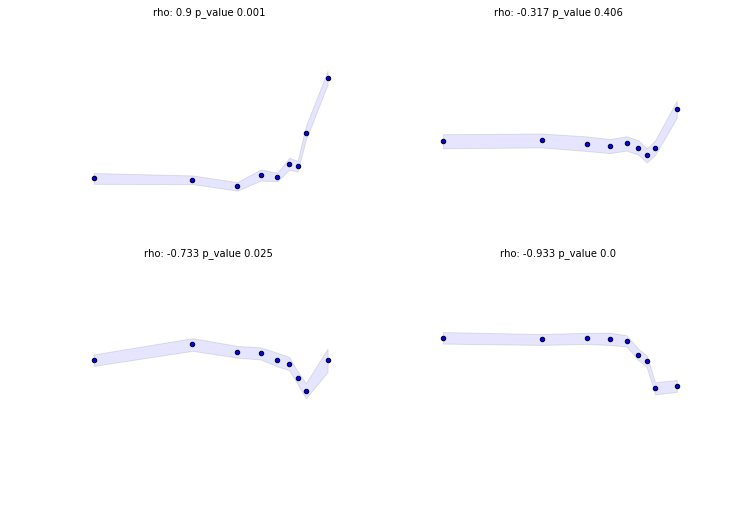

spontaneous


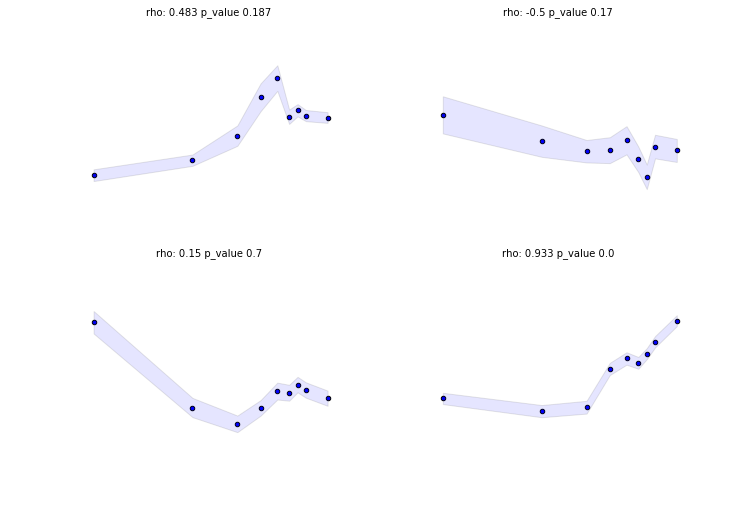

natural


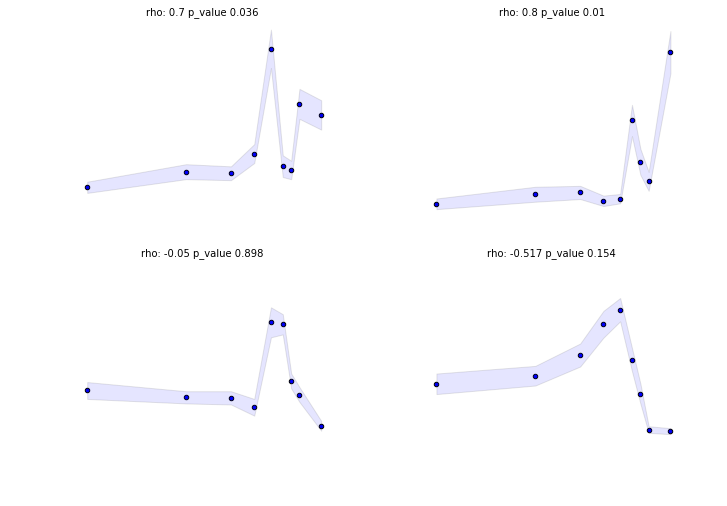

In [629]:

for ds in rs_results.keys():
    stim_results = rs_results[ds]  
    
    
    for stimulus in stim_results.keys():
       
        print stimulus
    
        neural_responses, results = stim_results[stimulus]
        
        num_rows, num_cols = 2, 2
        fig = plt.figure(figsize=(10,7))
        gs = gridspec.GridSpec(num_rows, num_cols, wspace=0.0)

        ax = [plt.subplot(gs[i]) for i in range(num_rows*num_cols)]
        gs.update(hspace=0)
        gs.tight_layout(fig, h_pad=0,w_pad=0)
        
        for i, k in enumerate(results.keys()):
            
            rho, p = results[k]

            ax[i].scatter(x, neural_responses[k][:, 0])
            ax[i].fill_between(x, neural_responses[k][:, 0] - neural_responses[k][:, 1],neural_responses[k][:, 0] + neural_responses[k][:, 1], alpha = .1)
            ax[i].axis('off')
            ax[i].set_title('rho: '+ str(round(rho, 3)) + ' p_value ' + str(round(p, 3)), fontsize = 10)


            #ax[i].plot(x, caran_curve(x,*copt_inc), c = 'r', label = "high pass")
            #ax[i].plot(x, caran_curve(x,*copt_dec), c = 'g', label = "low pass")
            #ax[i].plot(x, caran_curve(x,*copt_band), c = 'm', label = "bandpass")
            #ax[i].legend()

            #simpleaxis(ax[i])
  
            if i == (num_rows*num_cols - 1):
                break
       
        plt.show()